# Performance assessment based on in-situ measurements

# Part 1: linear regression

## Simon Rouchier - Université Savoie Mont-Blanc

This document is a modest attempt at estimating the overall heat loss coefficient of a house by linear regression. The method used here is a **stationary energy signature method**:

$$ P_h = H \: (T_{in} - T_{ext}) $$

where $P_h$, $T_{in}$ and $T_{ext}$ are averaged heating power, indoor and outdoor temperatures.

This equation is way too simple for our needs, since the house also receives heat from the sun, a mechanical ventilation with heat recovery, occupants, etc. The house is adjacent to another one, which has available temperature measurements as well. If I only use this equation, I will probably get a very wrong estimation of $H$.

# Loading the data

Let us first look at the data itself, before applying selection among the available sensors. The main data file is provided in the workshop folder as `GainsboroughData.csv`. The following block of code loads the data and ensures it is indexed with date and time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_all = pd.read_csv('GainsboroughData.csv')
data_all.set_index(pd.to_datetime(data_all.Time), inplace=True)

We can define a small function that will let us look at any column of the data easily

In [2]:
%matplotlib inline

def plot_obs(data, labels):
    plt.figure(figsize=(12,6))
    plt.plot(data[labels])
    plt.legend(labels)
    plt.show()

First, let's look at temperatures over the whole year of measurements:
* temperature in the lounge
* outdoor temperature
* supply temperature of the mechanical ventilation with heat recovery

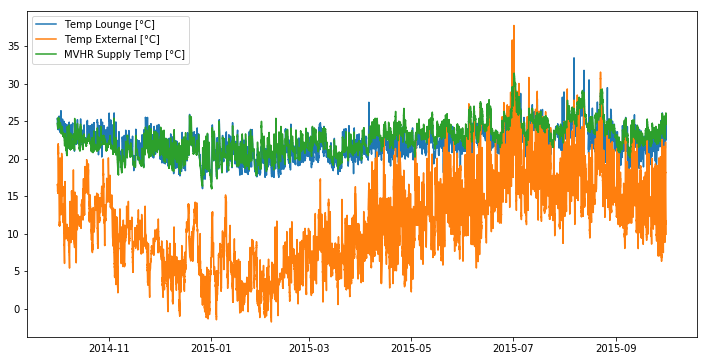

In [3]:
plot_obs(data_all, ['Temp Lounge [°C]', 'Temp External [°C]', 'MVHR Supply Temp [°C]'])

And we can also plot the space heating power:

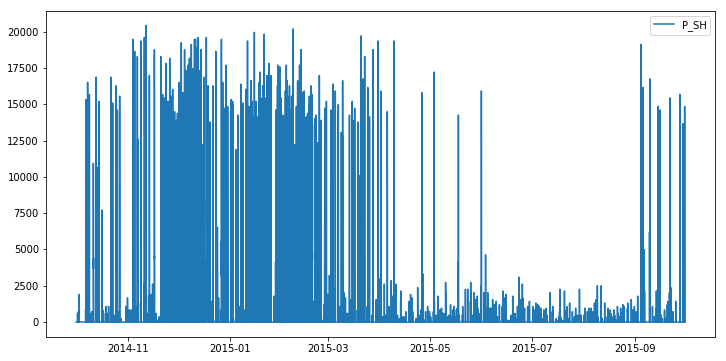

In [4]:
plot_obs(data_all, ['P_SH'])

Note: this space heating power was estimated prior to this workshop by clever machine learning tricks. This is why it is not exactly zero in summer as it should be.

As an exercise, you can plot other parts of the data and try to find which ones can help us estimate $H$ reliably.

The lounge and bedroom have clearly distinct temperatures. The MVHR supply temperature seems to closely follow the lounge temperature. Both temperature measurements from the adjacent house are displayed here as well: they are sometimes higher, sometimes lower than the temperatures of house 1.

# Methodology and data selection

As an example for this workshop, I propose a slightly better model than the simple formula shown above. It is based on a very simplified steady-state heat balance over the house, represented by a single temperature zone.

$$ E_h = -\alpha \: I_{sol} + \Delta t  \left[ H \: (T_{in} - T_{ext}) + H_{part} \; (T_i-T_{adj}) - q_{sup} \, c_p \: (T_i-T_{sup}) \right] - c $$

Where the following variables originate from the data:

* $\Delta t$ is the time step between each row of the data file. The original data has 5min time steps, but we will resample it to much larger durations (1 day, 3 days, 5 days...)
* $E_h$ is the heat consumption during each time step [J].
* $I_{sol}$ is the total solar radiation during each time step [J]
* $T_{in}$ is the indoor temperature of house 1, averaged between the lounge and the bedroom.
* $T_{ext}$ is the outdoor temperature.
* $T_{adj}$ is the average temperature of the adjacent house. 
* $T_{sup}$ is the MVHR supply temperature. 

And the following variables are coefficients that will be estimated by linear regression:
* $H$ is the heat loss coefficient of house 1.
* $\alpha$ is a solar aperture coefficient.
* $H_{part}$ is the transmission coefficient of the partition wall.
* $q_{sup}$ and $c_p$ are respectively the flow rate and specific heat of the MVHR.
* $c$ is a constant

For convenience, we create a new database containing only the columns that we will use. All data related to electricity consumption, $CO_2$ and humidity is discarded: the method can certainly be improved by using some of this data in the future. We also create new columns containing each temperature difference of the above formula, since these are the indicators we will use in the linear regression.

In [5]:
data_new = pd.DataFrame(index=data_all.index)
data_new.index.name = 'Time'

# Temperatures
data_new['T_in']  = ( data_all['Temp Bed 1 [°C]'] + data_all['Temp Lounge [°C]'] )/2
data_new['T_ext'] = data_all['Temp External [°C]']
data_new['T_adj'] = ( data_all['Temp House 2 Bed 1 [°C]'] + data_all['Temp House 2 Lounge [°C]'] )/2
data_new['T_sup'] = data_all['MVHR Supply Temp [°C]']
# Total solar radiation during each 5 minute time step [J/m2]
data_new['E_sol'] = data_all['I_sol'] * 5 * 60
# Energy consumed during each 5 minute time step
data_new['E_hea'] = data_all['P_SH'] * 5 * 60
# New columns with the temperature differences
data_new['deltaT_1'] = data_new['T_in'] - data_new['T_ext']
data_new['deltaT_2'] = data_new['T_in'] - data_new['T_adj']
data_new['deltaT_3'] = data_new['T_in'] - data_new['T_sup']

We then define a function that will let us select any subset of this data: one week, one month, one year, etc. This function is defined as to resample the original data into larger time steps. Since the methodology supposes steady state, data will need to be averaged over time spans of at least one day.

In [6]:
def select_sample(data, start, stop, step):
    """
    Select a subsample from a dataset
    example : select_sample(data_new, start='2013-10-01', stop='2014-09-30', step='3D')
    """
    df1 = data.drop(data.index[(data.index < pd.to_datetime(start)) | (data.index > pd.to_datetime(stop))] )
    df = df1.resample(step).mean()
    # Energy consumption and solar radiation need to be adapted to the new time step size.
    df['E_hea'] *= len(df1) / len(df)
    df['E_sol'] *= len(df1) / len(df)
    return df

# First attempt at the estimation of $H$

Everything is ready to perform the estimation of $H$. We will be using linear regression from the `statsmodel` Python library.

The first training dataset uses the whole available year of measurements starting from October 2014. Data is averaged over time steps of 3 days.

In [7]:
import statsmodels.formula.api as smf

# Selection of the data subset
df_train = select_sample(data_new, '2014-10-01', '2015-09-30', '3D')
delta_t = (df_train.index[1] - df_train.index[0]).total_seconds()
# Training
lm = smf.ols(formula='E_hea ~  E_sol + deltaT_1 + deltaT_2 + deltaT_3', data=df_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  E_hea   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     80.89
Date:                Thu, 18 Oct 2018   Prob (F-statistic):           9.09e-33
Time:                        09:41:18   Log-Likelihood:                -2259.4
No. Observations:                 122   AIC:                             4529.
Df Residuals:                     117   BIC:                             4543.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.808e+07   1.39e+07     -2.024      0.0

The `summary()` function returns a lot of information about the fitness of our model.

* On the top-right corner, `R-squared` indicates the goodness-of-fit of the linear regression. A value around 0.8 seems acceptable, although it could certainly be improved by a better selection of the data.
* Results suggest that `deltaT_2` is statistically insignificant. This means that the temperature of the adjacent house has no impact on the heat balance of house 1.

As specified by our model, the heat transfer coefficient $H$ can be obtained from the coefficient of `deltaT_1`:

In [8]:
h_avg = lm.params['deltaT_1'] / delta_t
h_std = np.sqrt(lm.cov_params()['deltaT_1']['deltaT_1']) / delta_t

print('Heat transfer coefficient mean: %.2f W/K' %h_avg)
print('Heat transfer coefficient standard deviation: %.2f W/K' %h_std)

Heat transfer coefficient mean: 35.40 W/K
Heat transfer coefficient standard deviation: 3.67 W/K


The solar aperture coefficient is also a direct byproduct of this estimation:

In [9]:
alpha_avg = lm.params['E_sol']
alpha_std = np.sqrt(lm.cov_params()['E_sol']['E_sol'])

print('Solar aperture mean: %.3f m2' % -alpha_avg)
print('Solar aperture standard deviation: %.3f m2' % alpha_std)

Solar aperture mean: 1.035 m2
Solar aperture standard deviation: 0.182 m2


Finally let's plot the energy consumption versus the indoor-outdoor temperature difference, in order to see if our model seems to fit the data

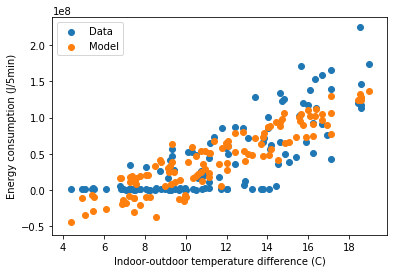

In [10]:
Epred =  lm.predict(df_train) # predict in sample

plt.figure()
plt.scatter(df_train['deltaT_1'], df_train['E_hea'], label='Data')
plt.scatter(df_train['deltaT_1'], Epred, label='Model')
plt.xlabel('Indoor-outdoor temperature difference (C)')
plt.ylabel('Energy consumption (J/5min)')
plt.legend()
plt.show()

There is at least one problem: a lot of data points have zero energy consumption. This drives the model towards negative values for the consumption if the indoor-outdoor temperature difference is low.

# Exercise

Try to change some settings in order to improve the identification. You can
* select a different subset of the data, and remove problematic data points
* simplify or complexify the model
* etc.